In [1]:
'''
'''

'\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import sklearn.model_selection
import sklearn.metrics

c:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# nome da saída
SENSOR = 'AGUA_NH3'

# Especificando pastas dos dados e das saidas
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

# Especificando a pasta para exportação das figuras
FIGURES_FOLDER = 'figures'

MODEL_NUM = 3

In [4]:
# importando dados
header = joblib.load(f'{OUTPUT_FOLDER}/DATA{MODEL_NUM}_columns_names_{SENSOR}.joblib')
data_array = joblib.load(f'{OUTPUT_FOLDER}/DATA{MODEL_NUM}_data_array_{SENSOR}.joblib')
print(header)
print(data_array[0])
print(data_array.shape)


['SW5-FC', 'SW1-FC', 'SW8-TC', 'ACG1-PC', 'C1S2-TC', 'C1S-LC', 'AMG1-TC', 'AMG1-PC', 'C2D-LC', 'C2S-LC', 'AGUA_NH3']
[ 0.26135819  0.26019135 -0.11366555  0.0541561  -0.6415407   1.02567346
  0.51334822 -0.14658078 -0.14351138 -0.55885101 -0.96188464]
(40315, 11)


In [5]:
# calculando e removendo outliers
SCALE = 1.7  # = 3 desvio padrão
# SCALE = 3.21 # = 5 desvio padrão
# SCALE = 6.91 # = 10 desvio padrão

Q1 = np.percentile(data_array, 25)
Q3 = np.percentile(data_array, 75)
IQR = Q3 - Q1 # interquartile range

lower_bound = Q1 - SCALE * IQR
upper_bound = Q3 + SCALE * IQR

outliers_mask = (data_array < lower_bound) | (data_array > upper_bound)
data_array[outliers_mask] = np.nan
data_array = data_array[~np.isnan(data_array).any(axis=1)]
print(data_array.shape)

(26792, 11)


In [6]:
# separando os dados de entrada e saída
data = data_array[:, :-1]
output = data_array[:, -1]
print(data[0])
print(output[0])

[ 0.26135819  0.26019135 -0.11366555  0.0541561  -0.6415407   1.02567346
  0.51334822 -0.14658078 -0.14351138 -0.55885101]
-0.961884644329764


In [7]:
# separando os dados entre treinamento e teste
train_data, test_data, train_output, test_output = train_test_split(data, output, test_size=0.10, random_state=42, shuffle=True)
print(train_data.shape)
print(test_data.shape)
print(train_output.shape)
print(test_output.shape)

(24112, 10)
(2680, 10)
(24112,)
(2680,)


In [8]:
# Otimização de Hiperparâmetros
def objetivo_rc(trial):
    # Hiperparâmetros de busca para RF
    rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 10, log = True)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 1, 50)

    # Criação do modelo RF
    m = sklearn.ensemble.RandomForestRegressor(max_depth = rf_max_depth, 
    min_samples_leaf = rf_min_samples_leaf, n_estimators = rf_n_estimators)

    # Retornando R² de validação, 20% dos dados de treino
    train__data, val_data, train__output, val_output = sklearn.model_selection.train_test_split(train_data, train_output, test_size=0.2, random_state=101) 
    
    # Converter train__output para vetor unidimensional
    train__output = train__output.ravel()

    m.fit(train__data, train__output)
    predictions_optimization = m.predict(val_data)
    r2 = sklearn.metrics.r2_score(val_output, predictions_optimization)

    #r2 = sklearn.metrics.mean_absolute_error(val_output, predictions_optimization) # se for usar Mean Absolute Error
    #r2 = sklearn.metrics.mean_squared_error(val_output, predictions_optimization) # se for usar Mean Squared Error
    #r2 = np.sqrt(sklearn.metrics.mean_squared_error(val_output, predictions_optimization)) se for usar Root Mean Squared Error

    # Salvando o modelo treinado
    joblib.dump(m, f'{OUTPUT_FOLDER}/RF{MODEL_NUM}_model_temp_{str(trial.number)}.joblib')

    return r2

# Resultados função objetivo
study_rc = optuna.create_study(direction="maximize")
n_trials = 40
print("Nº Iterações Otimização:", n_trials)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rc.optimize(objetivo_rc, n_trials=n_trials, show_progress_bar=True)
print("Hiperparâmetros Otimizados:", study_rc.best_params)
print("Melhor trial:", study_rc.best_trial.number)

[I 2024-08-24 20:56:02,087] A new study created in memory with name: no-name-ab3acfc0-5428-43e9-81b9-47fdeafd62e5


Nº Iterações Otimização: 40


Best trial: 21. Best value: 0.614448: 100%|██████████| 40/40 [03:08<00:00,  4.71s/it]

Hiperparâmetros Otimizados: {'rf_min_samples_leaf': 3, 'rf_max_depth': 10, 'rf_n_estimators': 17}
Melhor trial: 21


In [9]:
# import plotly.io as pio

# Gráficos otimização de hiperparâmetros
# fig1 = optuna.visualization.plot_optimization_history(study_rc)
# fig1.show()

# fig2 = optuna.visualization.plot_slice(study_rc)
# fig2.show()

# fig3 = optuna.visualization.plot_parallel_coordinate(study_rc)
# fig3.show() 

In [10]:
# Carregamento e teste do modelo RF com hiperparâmetros otimizados
loaded_model = joblib.load(f'{OUTPUT_FOLDER}/RF{MODEL_NUM}_model_temp_{str(study_rc.best_trial.number)}.joblib')
predictions = loaded_model.predict(test_data)  # teste
predictions_train = loaded_model.predict(train_data)  # treino

In [11]:
# Apagando modelos após uso
folder_path = os.path.join(os.getcwd(), OUTPUT_FOLDER)
for filename in os.listdir(folder_path):
    if filename.startswith(f"RF{MODEL_NUM}_model_temp"):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            os.remove(filepath)

In [12]:
print('Métricas Modelo - dados teste')
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(test_output, predictions))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(test_output, predictions))
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(test_output, predictions)))
print('R^2:', sklearn.metrics.r2_score(test_output, predictions))

Métricas Modelo - dados teste
Mean Absolute Error: 0.37758697169442423
Mean Squared Error: 0.25284042964601094
Root Mean Squared Error: 0.5028324071159405
R^2: 0.6275551687883302


In [13]:
print('Métricas Modelo - dados treino')
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(train_output, predictions_train))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(train_output, predictions_train))
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(train_output, predictions_train)))
print('R^2:', sklearn.metrics.r2_score(train_output, predictions_train))

Métricas Modelo - dados treino
Mean Absolute Error: 0.3374500502183906
Mean Squared Error: 0.20708111908219826
Root Mean Squared Error: 0.4550616651424269
R^2: 0.6857918306158439


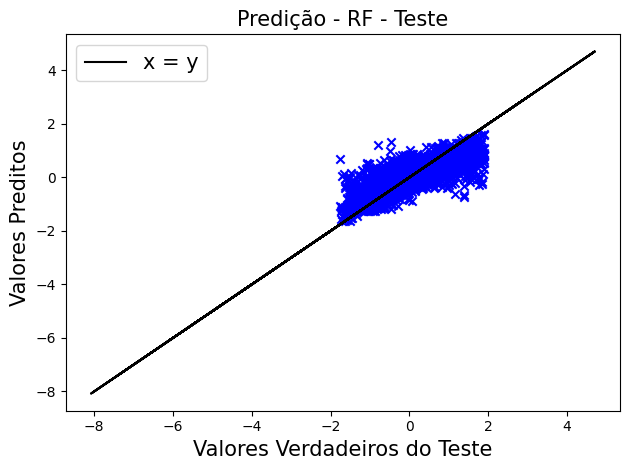

In [14]:
# Gráfico predição - teste
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(test_output, predictions, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('Valores Verdadeiros do Teste', fontsize=15)
plt.ylabel('Valores Preditos', fontsize=15)
plt.title('Predição - RF - Teste', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testpredictions.png')
plt.show()
plt.close()

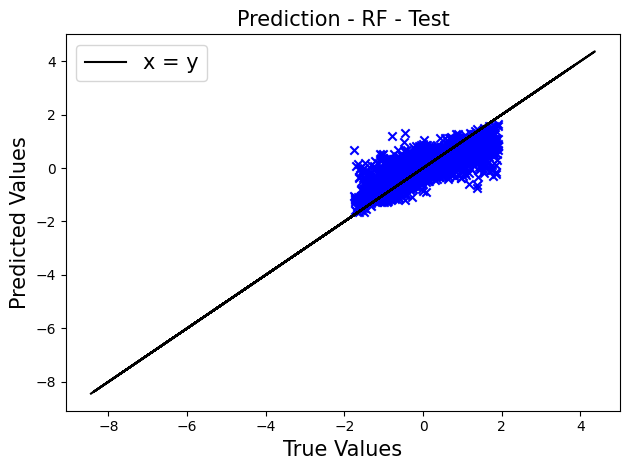

In [15]:
# Gráfico predição ingles - teste
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(test_output, predictions, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - RF - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testpredictions_eng.png')
plt.show()
plt.close()

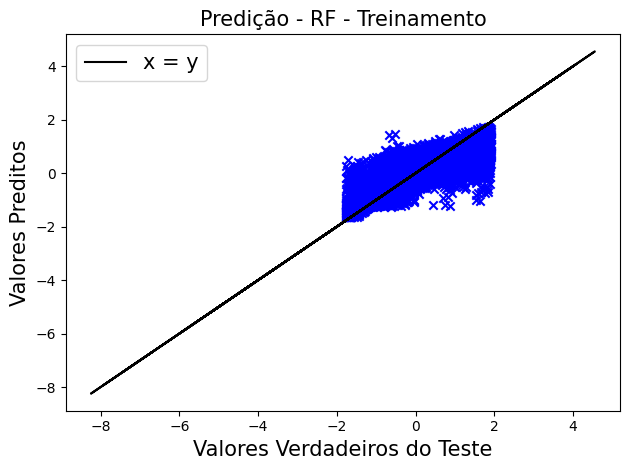

In [16]:
# Gráfico predição - treinamento
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50, ))
plt.plot(reta, reta, color='black', label='x = y')  #plot reta x = y
plt.scatter(train_output, predictions_train, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('Valores Verdadeiros do Teste', fontsize=15)
plt.ylabel('Valores Preditos', fontsize=15)
plt.title('Predição - RF - Treinamento', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainpredictions.png')
plt.show()
plt.close()

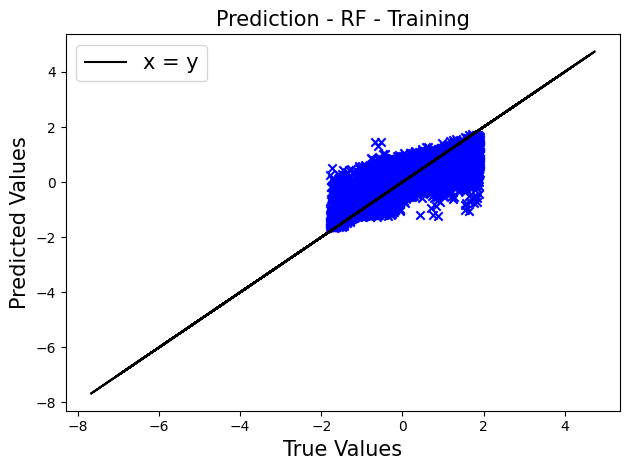

In [17]:
# Gráfico predição ingles - treinamento
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50, ))
plt.plot(reta, reta, color='black', label='x = y')  #plot reta x = y
plt.scatter(train_output, predictions_train, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - RF - Training', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainpredictions_eng.png')
plt.show()
plt.close()

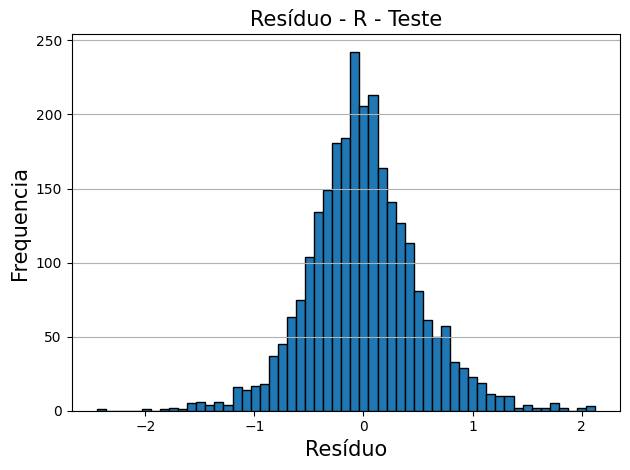

In [18]:
# Gráfico Resíduos - teste
residue = test_output.ravel() - predictions.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequencia', fontsize=15)
plt.xlabel('Resíduo', fontsize=15)
plt.title('Resíduo - R - Teste', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testresidue.png')
plt.show()
plt.close()

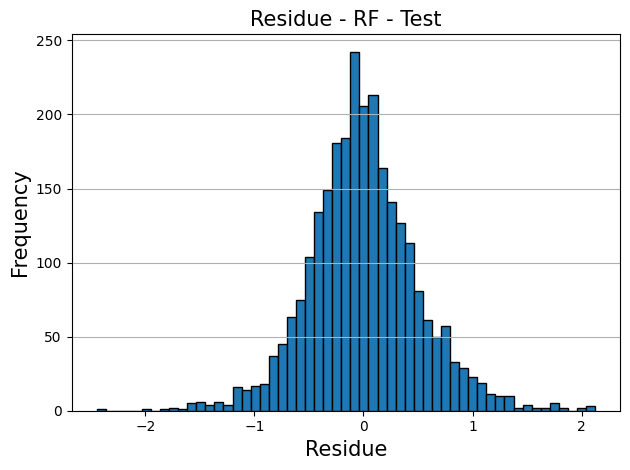

In [19]:
# Gráfico Resíduos ingles - teste
residue = test_output.ravel() - predictions.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - RF - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testresidue_eng.png')
plt.show()
plt.close()

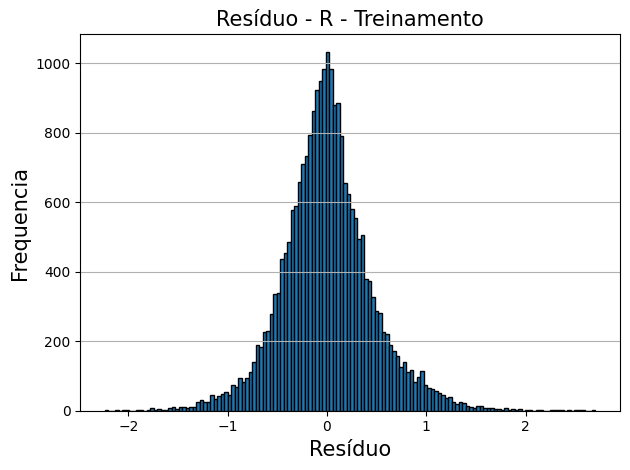

In [20]:
# Gráfico Resíduos - treinamento
residue = train_output.ravel() - predictions_train.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequencia', fontsize=15)
plt.xlabel('Resíduo', fontsize=15)
plt.title('Resíduo - R - Treinamento', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainresidue.png')
plt.show()
plt.close()

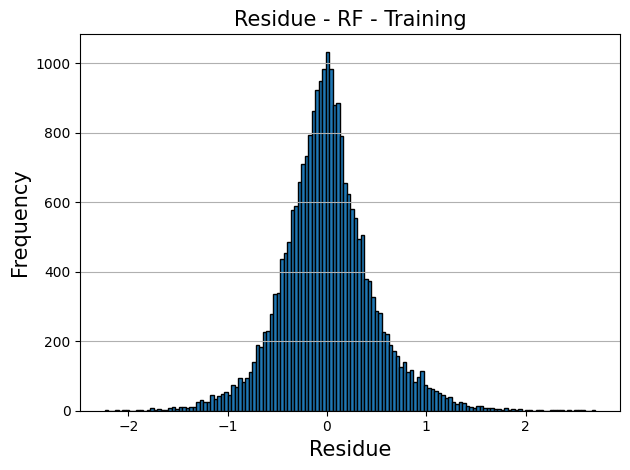

In [21]:
# Gráfico Resíduos ingles - treinamento
residue = train_output.ravel() - predictions_train.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - RF - Training', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainresidue_eng.png')
plt.show()
plt.close()

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Importância das variáveis
importances = list(loaded_model.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(header, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
[print('Variável: {:20} Importância: {}'.format(*pair)) for pair in feature_importances]

# Ajuste do tamanho do header
adjusted_header = list(itertools.islice(header, len(importances)))

Variável: SW8-TC               Importância: 0.2697
Variável: AMG1-TC              Importância: 0.1898
Variável: C1S2-TC              Importância: 0.1547
Variável: SW1-FC               Importância: 0.1067
Variável: SW5-FC               Importância: 0.0841
Variável: C1S-LC               Importância: 0.0841
Variável: C2D-LC               Importância: 0.0603
Variável: C2S-LC               Importância: 0.0344
Variável: ACG1-PC              Importância: 0.0102
Variável: AMG1-PC              Importância: 0.0061


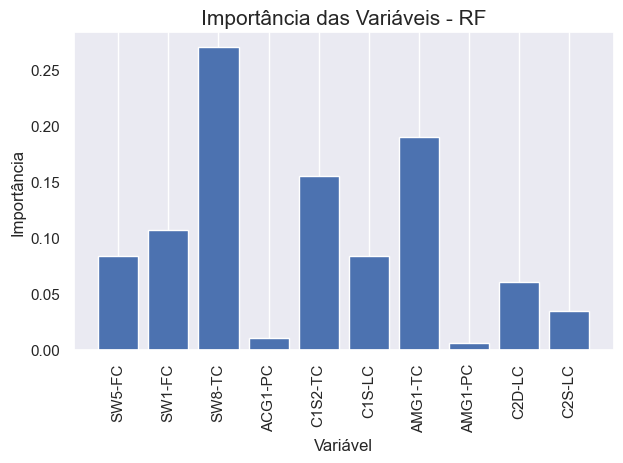

In [23]:
# Gráfico importância
sns.set(font_scale=1)
x_values = list(range(len(importances)))
plt.figure()
plt.grid(axis='y')
plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, adjusted_header, rotation='vertical')
plt.ylabel('Importância')
plt.xlabel('Variável')
plt.title('Importância das Variáveis - RF', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_RF_importance.png')
plt.show()
plt.close()

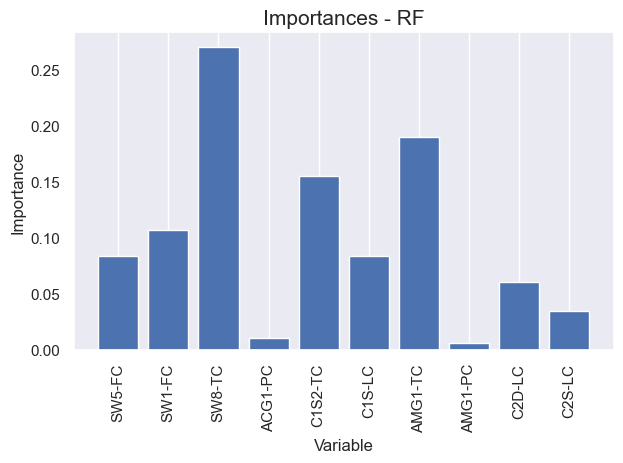

In [24]:
# Gráfico importância ingles
sns.set(font_scale=1)
x_values = list(range(len(importances)))
plt.figure()
plt.grid(axis='y')
plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, adjusted_header, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Importances - RF', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_RF_importance_eng.png')
plt.show()
plt.close()

In [25]:
# ----------------- Redução variáveis pela importância -----------------
print("------------------ REDUÇÃO DE VARIÁVEIS -------------------\n")
MIN_IMPORTANCE = 0.05  # Critério para redução
# Quantidade de variáveis que serão utilizadas na redução
columns = sum(big > MIN_IMPORTANCE for big in importances)
# Criando vetor reduzido dados treino
train_data_red = np.zeros((train_data.shape[0], columns))
# Criando vetor reduzido dados teste
test_data_red = np.zeros((test_data.shape[0], columns))
# Criando vetor reduzido header
header_red = []
fix_pos = 0  # Contador dos dados reduzidos
total_importance = 0  # Soma da importância total das variáveis reduzidas
for pos, item in enumerate(importances):
    if item > MIN_IMPORTANCE: 
        train_data_red[:, fix_pos] = train_data[:, pos]
        test_data_red[:, fix_pos] = test_data[:, pos]
        header_red.append(header[pos])
        fix_pos = fix_pos + 1
        total_importance = total_importance + item

print("Importância total da versão reduzida:", total_importance)
print("Formato dos dados de entrada de treinamento reduzidos:", train_data_red.shape)
print("Formato dos dados de de entrada de teste reduzidos:", test_data_red.shape)
print("Formato do header reduzido:", len(header_red))
print("Header reduzido:", header_red)

------------------ REDUÇÃO DE VARIÁVEIS -------------------

Importância total da versão reduzida: 0.9493409778184306
Formato dos dados de entrada de treinamento reduzidos: (24112, 7)
Formato dos dados de de entrada de teste reduzidos: (2680, 7)
Formato do header reduzido: 7
Header reduzido: ['SW5-FC', 'SW1-FC', 'SW8-TC', 'C1S2-TC', 'C1S-LC', 'AMG1-TC', 'C2D-LC']


In [26]:
# Criação, treinamento e teste do modelo RF com hiperparâmetros otimizados
print("Hiperparâmetros Otimizados:", study_rc.best_params)
m_red = sklearn.ensemble.RandomForestRegressor(max_depth = study_rc.best_params['rf_max_depth'],
min_samples_leaf = study_rc.best_params['rf_min_samples_leaf'],
n_estimators = study_rc.best_params['rf_n_estimators'])

m_red.fit(train_data_red, train_output.ravel())  # treinamento
predictions2 = m_red.predict(test_data_red)  # teste
predictions2_train = m_red.predict(train_data_red)  # treino

Hiperparâmetros Otimizados: {'rf_min_samples_leaf': 3, 'rf_max_depth': 10, 'rf_n_estimators': 17}


In [27]:
print('Métricas Modelo Reduzido - dados teste')
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(test_output, predictions2))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(test_output, predictions2))
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(test_output, predictions2)))
print('R^2:', sklearn.metrics.r2_score(test_output, predictions2))

Métricas Modelo Reduzido - dados teste
Mean Absolute Error: 0.3758680704390277
Mean Squared Error: 0.24898410212516114
Root Mean Squared Error: 0.4989830679744165
R^2: 0.6332357051432583


In [28]:
print('Métricas Modelo Reduzido - dados treino')
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(train_output, predictions2_train))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(train_output, predictions2_train))
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(train_output, predictions2_train)))
print('R^2:', sklearn.metrics.r2_score(train_output, predictions2_train))

Métricas Modelo Reduzido - dados treino
Mean Absolute Error: 0.3357664305028709
Mean Squared Error: 0.2045073653873846
Root Mean Squared Error: 0.45222490575750535
R^2: 0.6896970366552806


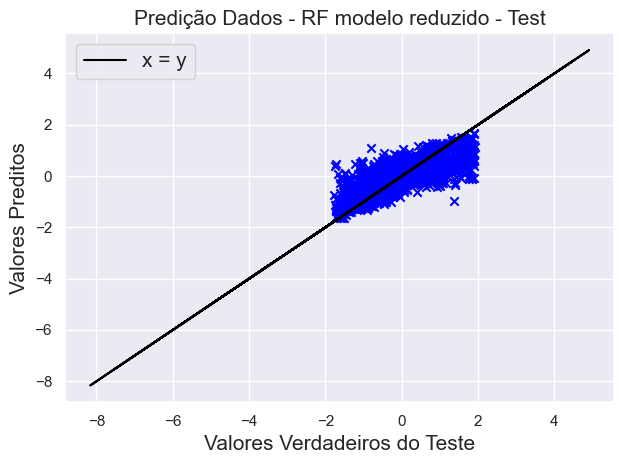

In [29]:
# Gráfico predição modelo reduzido - teste
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(test_output, predictions2, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('Valores Verdadeiros do Teste', fontsize=15)
plt.ylabel('Valores Preditos', fontsize=15)
plt.title('Predição Dados - RF modelo reduzido - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testpredictions_reduced.png')
plt.show()
plt.close()

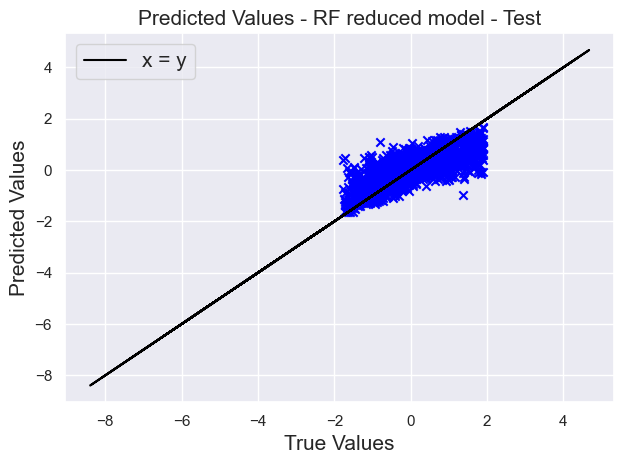

In [30]:
# Gráfico predição modelo reduzido ingles - teste
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(test_output, predictions2, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Predicted Values - RF reduced model - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testpredictions_reduced_eng.png')
plt.show()
plt.close()

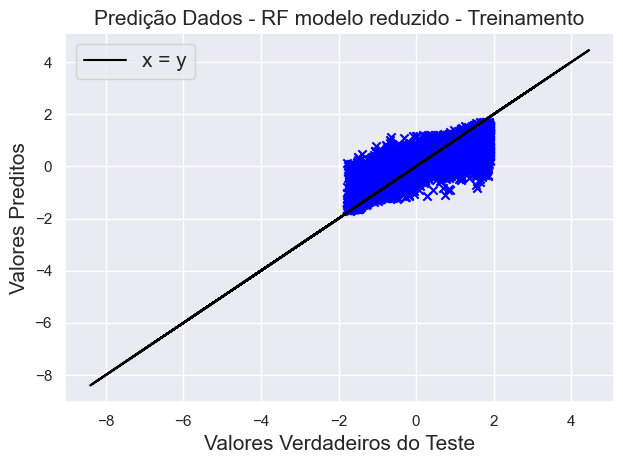

In [31]:
# Gráfico predição modelo reduzido - treinamento
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50, ))
plt.plot(reta, reta, color='black', label='x = y')  #plot reta x = y
plt.scatter(train_output, predictions2_train, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('Valores Verdadeiros do Teste', fontsize=15)
plt.ylabel('Valores Preditos', fontsize=15)
plt.title('Predição Dados - RF modelo reduzido - Treinamento', fontsize=15)
plt.tight_layout()
plt.savefig(
    f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainpredictions_reduced.png')
plt.show()
plt.close()

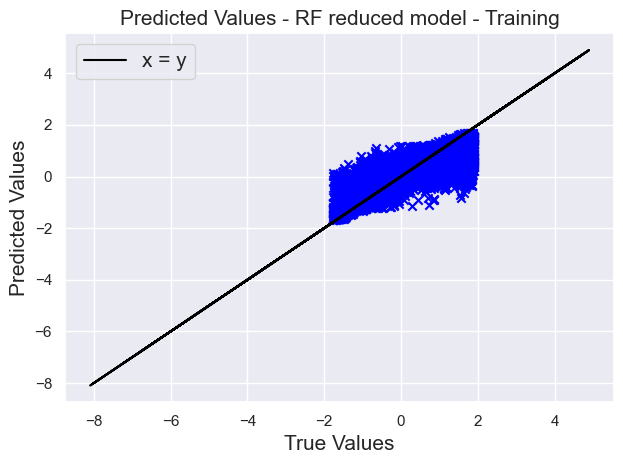

In [32]:
# Gráfico predição modelo reduzido ingles - treinamento
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50, ))
plt.plot(reta, reta, color='black', label='x = y')  #plot reta x = y
plt.scatter(train_output, predictions2_train, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Predicted Values - RF reduced model - Training', fontsize=15)
plt.tight_layout()
plt.savefig(
    f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainpredictions_reduced_eng.png')
plt.show()
plt.close()

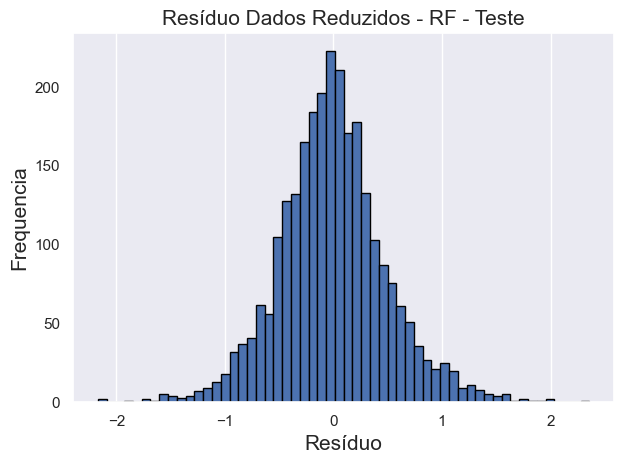

In [33]:
# Gráfico Resíduos modelo reduzido - teste
residue2_test = test_output.ravel() - predictions2.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue2_test, bins='auto', ec='black')
plt.ylabel('Frequencia', fontsize=15)
plt.xlabel('Resíduo', fontsize=15)
plt.title('Resíduo Dados Reduzidos - RF - Teste', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testresidue_reduced.png')
plt.show()
plt.close()

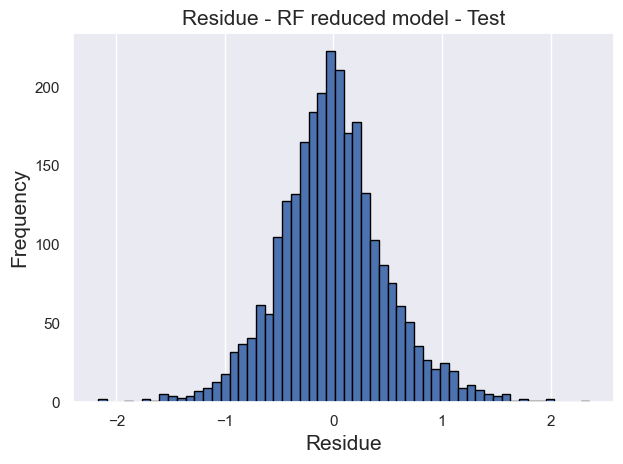

In [34]:
# Gráfico Resíduos modelo reduzido ingles - teste
residue2_test = test_output.ravel() - predictions2.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue2_test, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - RF reduced model - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_testresidue_reduced_eng.png')
plt.show()
plt.close()

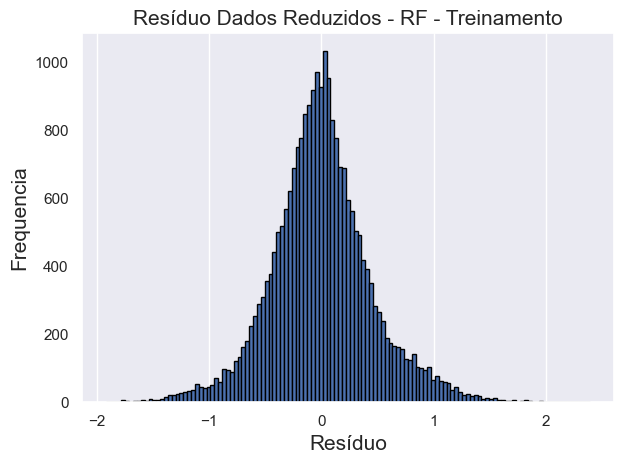

In [35]:
# Gráfico Resíduos modelo reduzido - treinamento
residue2_train = train_output.ravel() - predictions2_train.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue2_train, bins='auto', ec='black')
plt.ylabel('Frequencia', fontsize=15)
plt.xlabel('Resíduo', fontsize=15)
plt.title('Resíduo Dados Reduzidos - RF - Treinamento', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainresidue_reduced.png')
plt.show()
plt.close()

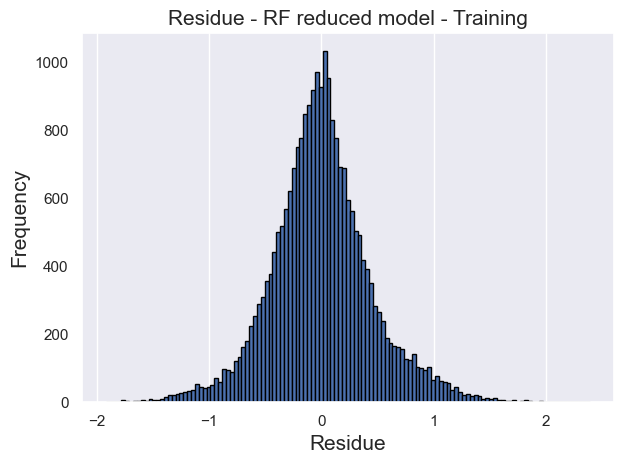

In [36]:
# Gráfico Resíduos modelo reduzido ingles - treinamento
residue2_train = train_output.ravel() - predictions2_train.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue2_train, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - RF reduced model - Training', fontsize=15)
plt.tight_layout()
plt.savefig(
    f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_trainresidue_reduced_eng.png')
plt.show()
plt.close()

Variável: SW8-TC               Importância: 0.296
Variável: AMG1-TC              Importância: 0.2141
Variável: C1S2-TC              Importância: 0.1514
Variável: SW1-FC               Importância: 0.1076
Variável: C1S-LC               Importância: 0.0902
Variável: SW5-FC               Importância: 0.0896
Variável: C2D-LC               Importância: 0.0511


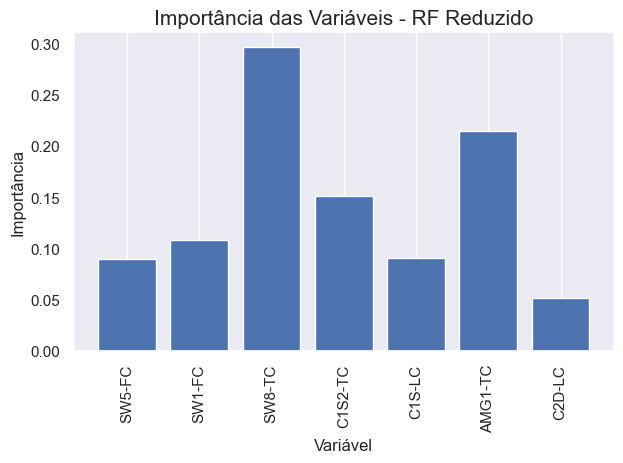

In [37]:
# Importância das variáveis
importances2 = list(m_red.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(header_red, importances2)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
[print('Variável: {:20} Importância: {}'.format(*pair)) for pair in feature_importances]

# Gráfico importância
sns.set(font_scale=1)
x_values = list(range(len(importances2)))
plt.figure()
plt.grid(axis='y')
plt.bar(x_values, importances2, orientation='vertical')
plt.xticks(x_values, header_red, rotation='vertical')
plt.ylabel('Importância')
plt.xlabel('Variável')
plt.title('Importância das Variáveis - RF Reduzido', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_importance_reduced.png')
plt.show()
plt.close()

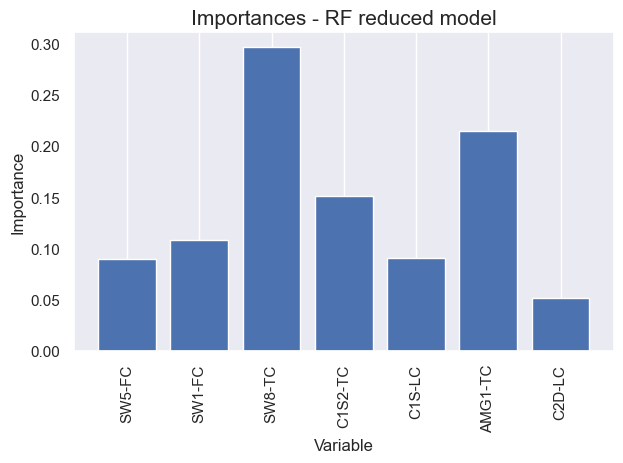

In [38]:
# Gráfico importância
sns.set(font_scale=1)
x_values = list(range(len(importances2)))
plt.figure()
plt.grid(axis='y')
plt.bar(x_values, importances2, orientation='vertical')
plt.xticks(x_values, header_red, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Importances - RF reduced model', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/RF{MODEL_NUM}_{SENSOR}_importance_reduced_eng.png')
plt.show()
plt.close()

In [39]:
# exportando o modelo reduzido
joblib.dump(m_red, f'{OUTPUT_FOLDER}/RF{MODEL_NUM}_model_red_{SENSOR}.joblib')

['output_files/RF3_model_red_AGUA_NH3.joblib']

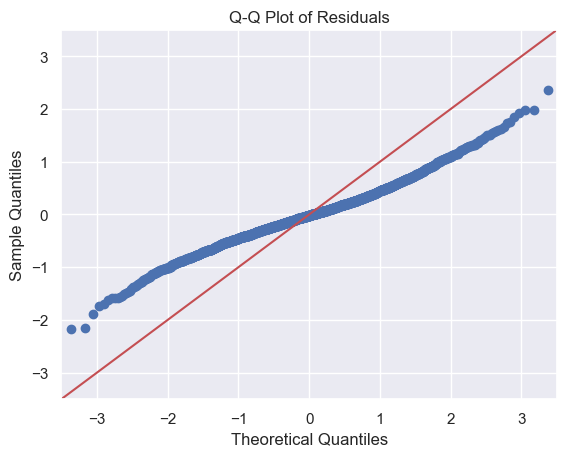

Shapiro-Wilk Test: ShapiroResult(statistic=np.float64(0.9875866110360819), pvalue=np.float64(1.5285404634321932e-14))
Kolmogorov-Smirnov Test: KstestResult(statistic=np.float64(0.04417052208339378), pvalue=np.float64(5.5588439778776306e-05), statistic_location=np.float64(0.23719418853824725), statistic_sign=np.int8(1))


In [40]:
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as stats

# # 1. Visual Inspection: Q-Q Plot
qqplot(residue2_test, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Statistical Tests on residue
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(residue2_test)
print("Shapiro-Wilk Test:", shapiro_test)

# Anderson-Darling Test
# anderson_test = stats.anderson(residue2_test, dist='norm')
# print("Anderson-Darling Test:", anderson_test)

# Kolmogorov-Smirnov Test
ks_test = stats.kstest(residue2_test, 'norm', args=(np.mean(residue2_test), np.std(residue2_test)))
print("Kolmogorov-Smirnov Test:", ks_test)

In [41]:
# # 1. Visual Inspection: Q-Q Plot
# qqplot(residue2_train, line='45')
# plt.title("Q-Q Plot of Residuals")
# plt.show()

# Statistical tests on residue
# Shapiro-Wilk
shapiro_train = stats.shapiro(residue2_train)
print("Shapiro-Wilk train:", shapiro_train)

# # Anderson-Darling
# anderson_train = stats.anderson(residue2_train, dist='norm')
# print("Anderson-Darling train:", anderson_train)

# Kolmogorov-Smirnov
ks_train = stats.kstest(residue2_train, 'norm', args=(np.mean(residue2_train), np.std(residue2_train)))
print("Kolmogorov-Smirnov train:", ks_train)

Shapiro-Wilk train: ShapiroResult(statistic=np.float64(0.983205416024139), pvalue=np.float64(1.3417099578952612e-45))
Kolmogorov-Smirnov train: KstestResult(statistic=np.float64(0.04905743330264789), pvalue=np.float64(7.197758565869337e-51), statistic_location=np.float64(0.19698105300640606), statistic_sign=np.int8(1))


c:\Program Files\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 24112.
  res = hypotest_fun_out(*samples, **kwds)


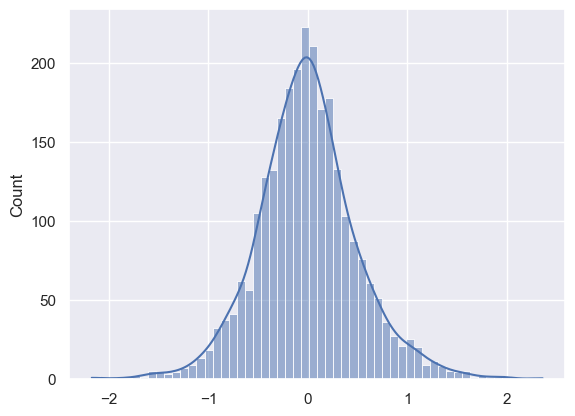

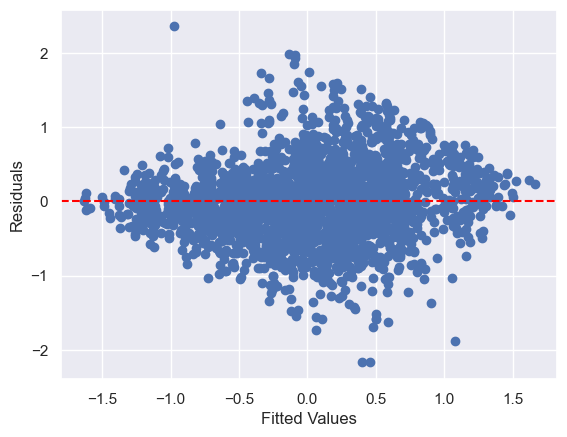

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of residuals
sns.histplot(residue2_test, kde=True)
plt.show()

# Residuals vs. Fitted Values
plt.scatter(predictions2, residue2_test)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


In [43]:
from scipy.stats import jarque_bera
jb_test = jarque_bera(residue2_test)
print("Jarque-Bera Test:", jb_test)

Jarque-Bera Test: SignificanceResult(statistic=np.float64(192.55380705632675), pvalue=np.float64(1.5398274698531723e-42))


In [44]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Add a constant column to X_train
test_data_red_with_constant = sm.add_constant(test_data_red)

# Perform the Breusch-Pagan test
test_result = het_breuschpagan(residue2_test, test_data_red_with_constant)
print("Breusch-Pagan Test:", test_result)

Breusch-Pagan Test: (np.float64(85.21738933721151), np.float64(1.1832233860011543e-15), np.float64(12.536192730604542), np.float64(6.699195788122883e-16))


In [49]:
import pandas as pd
import numpy as np

# Determine the maximum length
max_length = max(len(residue2_train), len(residue2_test))

# Pad the shorter array with NaN values
residue2_train_padded = np.pad(residue2_train, (0, max_length - len(residue2_train)), 'constant', constant_values=np.nan)
residue2_test_padded = np.pad(residue2_test, (0, max_length - len(residue2_test)), 'constant', constant_values=np.nan)

# Create a dictionary with the padded arrays
residuals = {
    'residue2_train': residue2_train_padded,
    'residue2_test': residue2_test_padded
}

# Convert the dictionary into a DataFrame
df_residuals = pd.DataFrame(residuals)

# Export the DataFrame to a CSV file
df_residuals.to_csv('residuals_reduced_model.csv', index=False)
